In [1]:
import numpy as np
import datetime as DT


import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
"""Format data for analysis.""" 
Travisdf = pd.read_csv(r"C:\Users\140318\Desktop\Python\Python3x\Austin-Crash-Analytics\Spatial\csv\TravisMaster.csv")
Travisdf['Crash_Date'] = pd.to_datetime(Travisdf['Crash_Date'], format='%Y-%m-%d %X')
Travisdf['Crash_Time'] = pd.to_datetime(Travisdf['Crash_Time']).dt.hour
Travisdf=Travisdf.set_index('Crash_ID')
sev_codes = ['UNKNOWN',
            'INCAPACITATING INJURY',
            'NON-INCAPACITATING INJURY',
            'POSSIBLE INJURY',
            'KILLED',
            'NOT INJURED']
Travisdf['Crash_Severity_Code'] = Travisdf['Crash_Sev_ID'] 
Travisdf['Crash_Severity_Code'].replace({0:0, 1:4, 2:3, 3:2, 4:5, 5:1}, inplace=True)
Travisdf['Death_Cnt'].replace(0, np.NaN, inplace=True)
i = 0
for code in sev_codes:
    Travisdf['Crash_Sev_ID'].replace(i, code, inplace=True)
    i += 1


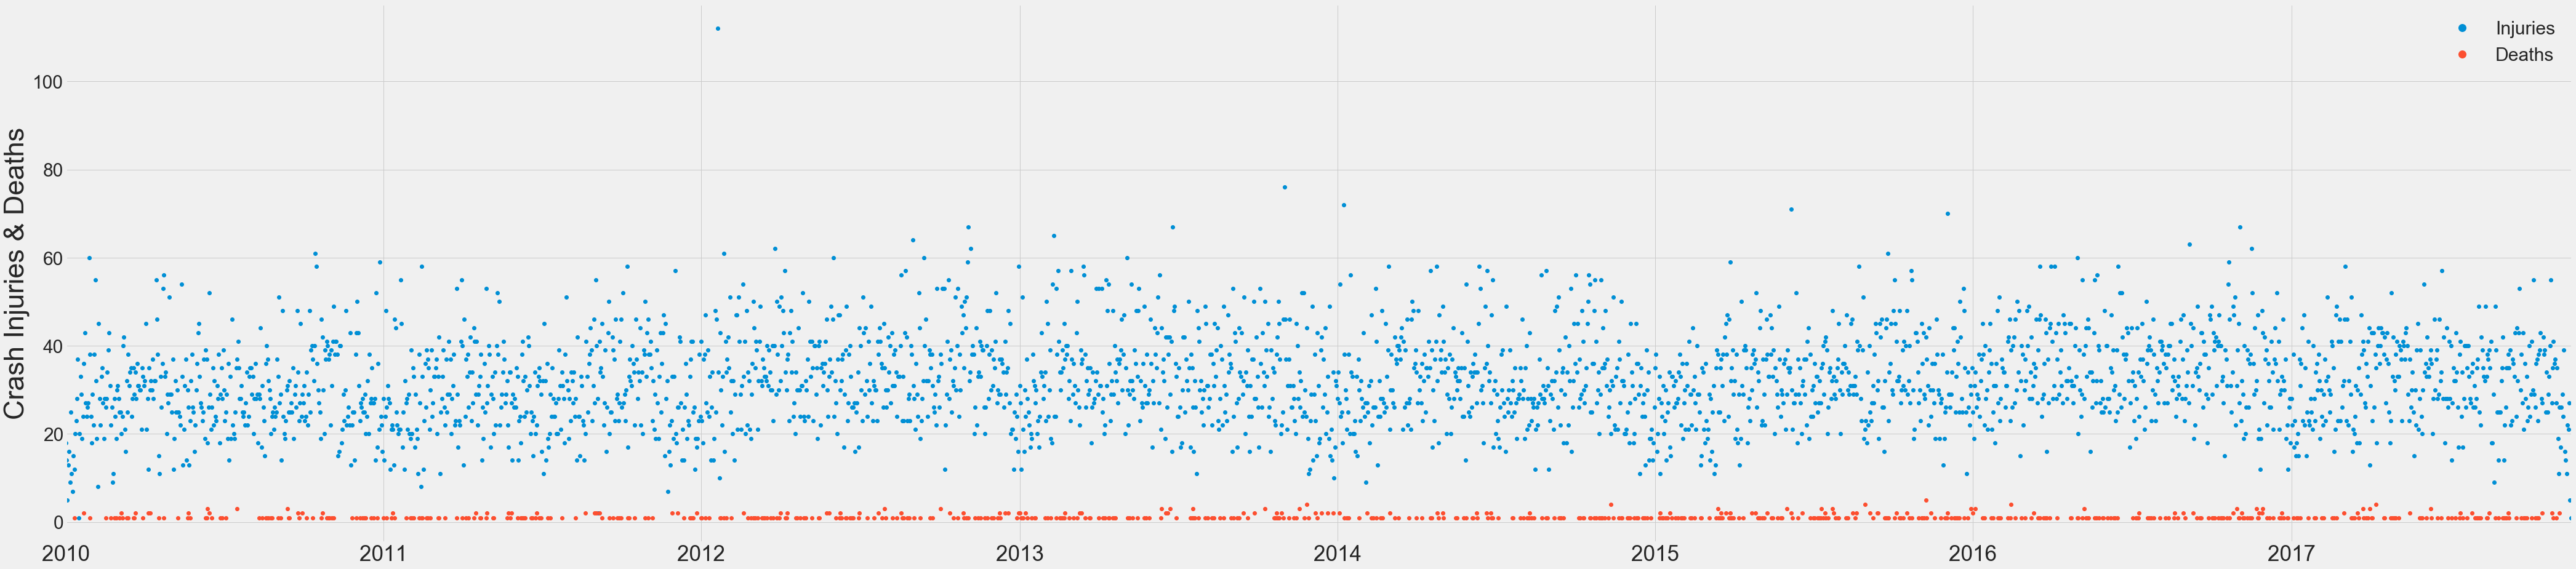

In [11]:
Travisdf.groupby(['Crash_Date'])[['Tot_Injry_Cnt', 'Death_Cnt']].sum().plot(figsize=(65,15),
                                                                            linestyle='',
                                                                            marker='o', grid=1)
plt.style.use('fivethirtyeight') 
plt.xlabel('')
plt.xticks(fontsize=35)
plt.yticks(fontsize=30)
plt.ylabel('Crash Injuries & Deaths', fontsize=45)
plt.legend(['Injuries', 'Deaths'], markerscale = 2, fontsize=30)
plt.show()

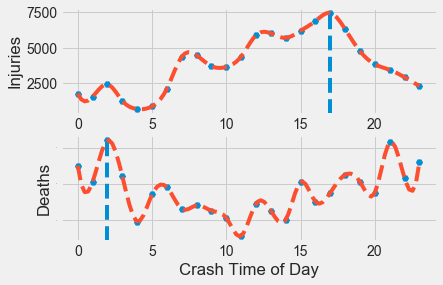

In [42]:
hourly = Travisdf.groupby(['Crash_Time'])[['Tot_Injry_Cnt', 'Death_Cnt']].sum().reset_index()
plt.figure(figsize=(50,20))
plt.style.use('fivethirtyeight') 
f, axes = plt.subplots(2, 1)
plt.yticks(size=0)
axes[0].axvline(x=17, linestyle='--')
axes[1].axvline(x=2, linestyle='--')

Y = np.array(list(hourly['Crash_Time']))
P = np.array(list(hourly['Tot_Injry_Cnt']))
f2 = interp1d(Y, P, kind='cubic')
xnew = np.linspace(min(Y), max(Y), 100)
axes[0].plot(Y, P, 'H', xnew, f2(xnew), '--')
axes[0].set_ylabel('Injuries')



Y = np.array(list(hourly['Crash_Time']))
P = np.array(list(hourly['Death_Cnt']))
f2 = interp1d(Y, P, kind='cubic')
xnew = np.linspace(min(Y), max(Y), 100)
axes[1].plot(Y, P, 'H', xnew, f2(xnew), '--')
axes[1].set_ylabel('Deaths')
axes[1].set_xlabel('Crash Time of Day')
plt.show()